<a href="https://colab.research.google.com/github/kaylawwong/Computer-Vision-Project/blob/aedrian2/ComputerVisionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1> <b> Classification of Fresh VS Spoiled Produce Using YOLO <b> </h1></center>

Importing required Libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil

from google.colab import drive
drive.mount('/content/drive')

%pip install ultralytics
import ultralytics
ultralytics.checks()
from ultralytics import YOLO

Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.5/112.6 GB disk)


# Dataset Description






Fruit Images for Classification

Available => https://data.mendeley.com/datasets/xkbjx8959c/2

- 5 different fruits:

    - Apple

    - Banana

    - Orange

    - Grape

    - Mango


# Data Preprocessing


Making directories according to above struture of folders

In [ ]:
import os, shutil, random

#paths
base_dir = ('/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset')
source_dir = ('/content/drive/MyDrive/IAT 360 Computer Vision Project/all_images')

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

#class folders - same as google drive
classes = [
    'apple_fresh', 'apple_rotten',
    'banana_fresh', 'banana_rotten',
    'orange_fresh', 'orange_rotten',
    'grape_fresh', 'grape_rotten',
    'mango_fresh', 'mango_rotten'
]

#create new folder structure for yolo
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

# split and copy (for training and validating)
split_ratio = 0.7 #70% train, 30% validating

for cls in classes:
  src_folder = os.path.join(source_dir, cls)
  images = os.listdir(src_folder)
  random.shuffle(images)

  split = int(len(images) * split_ratio)
  train_images = images[:split]
  val_images = images[split:]

  #copy to train and validatig folders
  for img in train_images:
    shutil.copy(os.path.join(src_folder, img), os.path.join(train_dir, cls))
  for img in val_images:
    shutil.copy(os.path.join(src_folder, img), os.path.join(val_dir, cls))

# **Visualizing some pictures from the dataset**

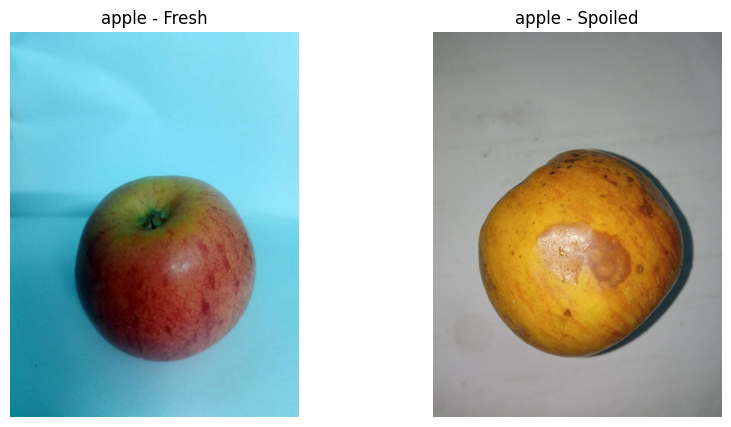

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import random

fruit = "apple" #can be changed to any fruit in the dataset to visualize

#paths for fresh and spoiled
fresh_path = os.path.join(train_dir, f"{fruit}_fresh")
spoiled_path = os.path.join(train_dir, f"{fruit}_rotten")

#randomly select 1 image from each
fresh_image = random.choice(os.listdir(fresh_path))
spoiled_image = random.choice(os.listdir(spoiled_path))

#load image
img_fresh = cv2.imread(os.path.join(fresh_path, fresh_image))
img_spoiled = cv2.imread(os.path.join(spoiled_path, spoiled_image))

img_fresh = cv2.cvtColor(img_fresh, cv2.COLOR_BGR2RGB)
img_spoiled = cv2.cvtColor(img_spoiled, cv2.COLOR_BGR2RGB)

#plot side by side
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img_fresh)
plt.title(f"{fruit} - Fresh")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_spoiled)
plt.title(f"{fruit} - Spoiled")
plt.axis('off')

plt.show()

# Custom object detection using YOLO

First install and import

In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.1/112.6 GB disk)


In [ ]:
from ultralytics import YOLO

## Training YOLO for Classification

In [ ]:
# check where runtime is from
!nvidia-smi
import torch
print(torch.backends.mps.is_available())

Wed Oct 29 22:27:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   71C    P0             29W /   70W |     102MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
model = YOLO('yolov8s-cls.pt') # pretrained classification model

In [4]:
#### THIS CODE SAVES THE DATASET LOCALLY FOR TEMPORARY USE


# # 1️⃣ Zip the dataset in Google Drive (if not already zipped)
# !cd "/content/drive/MyDrive/IAT 360 Computer Vision Project" && zip -r dataset.zip dataset

# 2️⃣ Copy the single zip file to Colab local storage
!cp "/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset.zip" /content/

# 3️⃣ Unzip it locally
!unzip /content/dataset.zip -d /content/

# 4️⃣ Confirm contents
!ls /content/dataset


Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/train/orange_fresh/WhatsApp Image 2024-06-22 at 10.40.25 PM.jpeg  
  inflating: /content/dataset/train/orange_fresh/WhatsApp Image 2024-06-22 at 10.40.45 PM.jpeg  
  inflating: /content/dataset/train/orange_fresh/WhatsApp Image 2024-06-22 at 10.37.33 PM (1).jpeg  
  inflating: /content/dataset/train/orange_fresh/WhatsApp Image 2024-06-21 at 11.10.21 PM.jpeg  
  inflating: /content/dataset/train/orange_fresh/msg5170347760-69422.jpg  
  inflating: /content/dataset/train/orange_fresh/WhatsApp Image 2024-06-21 at 11.10.34 PM.jpeg  
  inflating: /content/dataset/train/orange_fresh/WhatsApp Image 2024-06-21 at 11.11.06 PM.jpeg  
  inflating: /content/dataset/train/orange_fresh/msg5170347760-65539.jpg  
  inflating: /content/dataset/train/orange_fresh/msg5170347760-69274.jpg  
  inflating: /content/dataset/train/orange_fresh/WhatsApp Image 2024-06-22 at 10.37.35 PM (1).jpeg  
  inflating: /content/dataset/train/o

In [5]:
#### INITIAL HYPERPARAMETERS FOR V1

# model.train(
#     data="/content/dataset", # local copy
#     epochs=50,
#     patience=5,
#     batch=8,
#     lr0=0.001,
#     imgsz=640,
#     device = "cuda",
#     project="/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/runs",
#     name = "fresh_vs_rotten",
#     save = True,
#     save_period = 5,
# )

#### INITIAL HYPERPARAMETERS FOR V2, train to 10

# model.train(
#     data="/content/dataset", # local copy
#     epochs=10,
#     patience=3,
#     batch=8,
#     lr0=0.001,
#     imgsz=640,
#     device = "cuda",
#     project="/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/runs",
#     name = "fresh_vs_rotten_v2",
#     save = True,
#     save_period = 1,
# )

### HYEPRPARAMATERS FOR V3

# model.train(
#     data="/content/dataset", # local copy
#     epochs=3,
#     patience=3,
#     batch=8,
#     lr0=0.0003,
#     imgsz=640,
#     device = "cuda",
#     project="/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/runs",
#     name = "fresh_vs_rotten_v3",
#     save = True,
#     save_period = 1,
# )

### HYEPRPARAMATERS FOR V4

model.train(
    data="/content/dataset", # local copy
    epochs=1,
    patience=3,
    batch=8,
    lr0=0.00005,
    imgsz=640,
    device = "cuda",
    project="/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/runs",
    name = "fresh_vs_rotten_v4",
    save = True,
    save_period = 1,
)



# SET MODEL TO UNFINISHED FILE IF CONTINUING FROM LAST RUN

# model = YOLO("/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/runs/fresh_vs_rotten/weights/last.pt")

# model.train(
#     resume=True
# )

Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=5e-05, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fresh_vs_rotten_v42, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=3, perspective=0.0, plots=True, pose=1

ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7908d3f74800>
curves: []
curves_results: []
fitness: 0.9656324684619904
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9312649369239807, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9656324684619904}
save_dir: PosixPath('/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/runs/fresh_vs_rotten_v42')
speed: {'preprocess': 0.5380646754169609, 'inference': 2.70677352840122, 'loss': 0.0008398066822081434, 'postprocess': 0.001997682100274713}
task: 'classify'
top1: 0.9312649369239807
top5: 1.0

In [ ]:
##### RETRAIN MODEL FROM PRETRAINED WEIGHTS

# load trained model
model = YOLO("/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/runs/fresh_vs_rotten/weights/best.pt")

model.train(
    data="/content/dataset",
    epochs=50,
    patience=5,
    batch=8,
    imgsz=640,
    lr0=0.0005,   # learning rate lowered
    device="cuda",
    project="/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/runs",
    name="fine_tuned_model",
    pretrained=True,  # continues from weights loaded
    save = True,
    save_period = 5
    )

Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/runs/fresh_vs_rotten/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fine_tuned_model, nbs=64, nms=False, opset=None, optimize=False

ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d82f04584a0>
curves: []
curves_results: []
fitness: 0.9961813986301422
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9923627972602844, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9961813986301422}
save_dir: PosixPath('/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/runs/fine_tuned_model')
speed: {'preprocess': 0.5233781727884088, 'inference': 2.7845575326959997, 'loss': 0.0008099326970645278, 'postprocess': 0.002146507396037231}
task: 'classify'
top1: 0.9923627972602844
top5: 1.0

## Evaluation Metrics

**Choosing the Right Metrics**

Choosing the right metrics to evaluate often depends on the specific application.

- mAP: Suitable for a broad assessment of model performance.

- IoU: Essential when precise object location is crucial.

- Precision: Important when minimizing false detections is a priority.

- Recall: Vital when it's important to detect every instance of an object.

- F1 Score: Useful when a balance between precision and recall is needed.


In [ ]:
#### THIS IS THE VERSION 1 OF THE MODEL MODEL
model = YOLO("/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/runs/fresh_vs_rotten/weights/best.pt")

metrics = model.val(data="/content/dataset")
metrics.top1 # top1 accuracy
metrics.top5 # top5 accuracy

Ultralytics 8.3.222 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s-cls summary (fused): 30 layers, 5,088,010 parameters, 0 gradients, 12.5 GFLOPs
train: /content/dataset/train... found 4885 images in 10 classes ✅ 
val: /content/dataset/val... found 2095 images in 10 classes ✅ 
test: /content/dataset/test... found 60 images in 10 classes ✅ 
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2470.1±928.5 MB/s, size: 86.2 KB)
val: Scanning /content/dataset/val... 2095 images, 0 corrupt: 100% ━━━━━━━━━━━━ 2095/2095 3.8Mit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 131/131 1.7it/s 1:18
                   all      0.993          1
Speed: 0.7ms preprocess, 4.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/runs/classify/val2


1.0

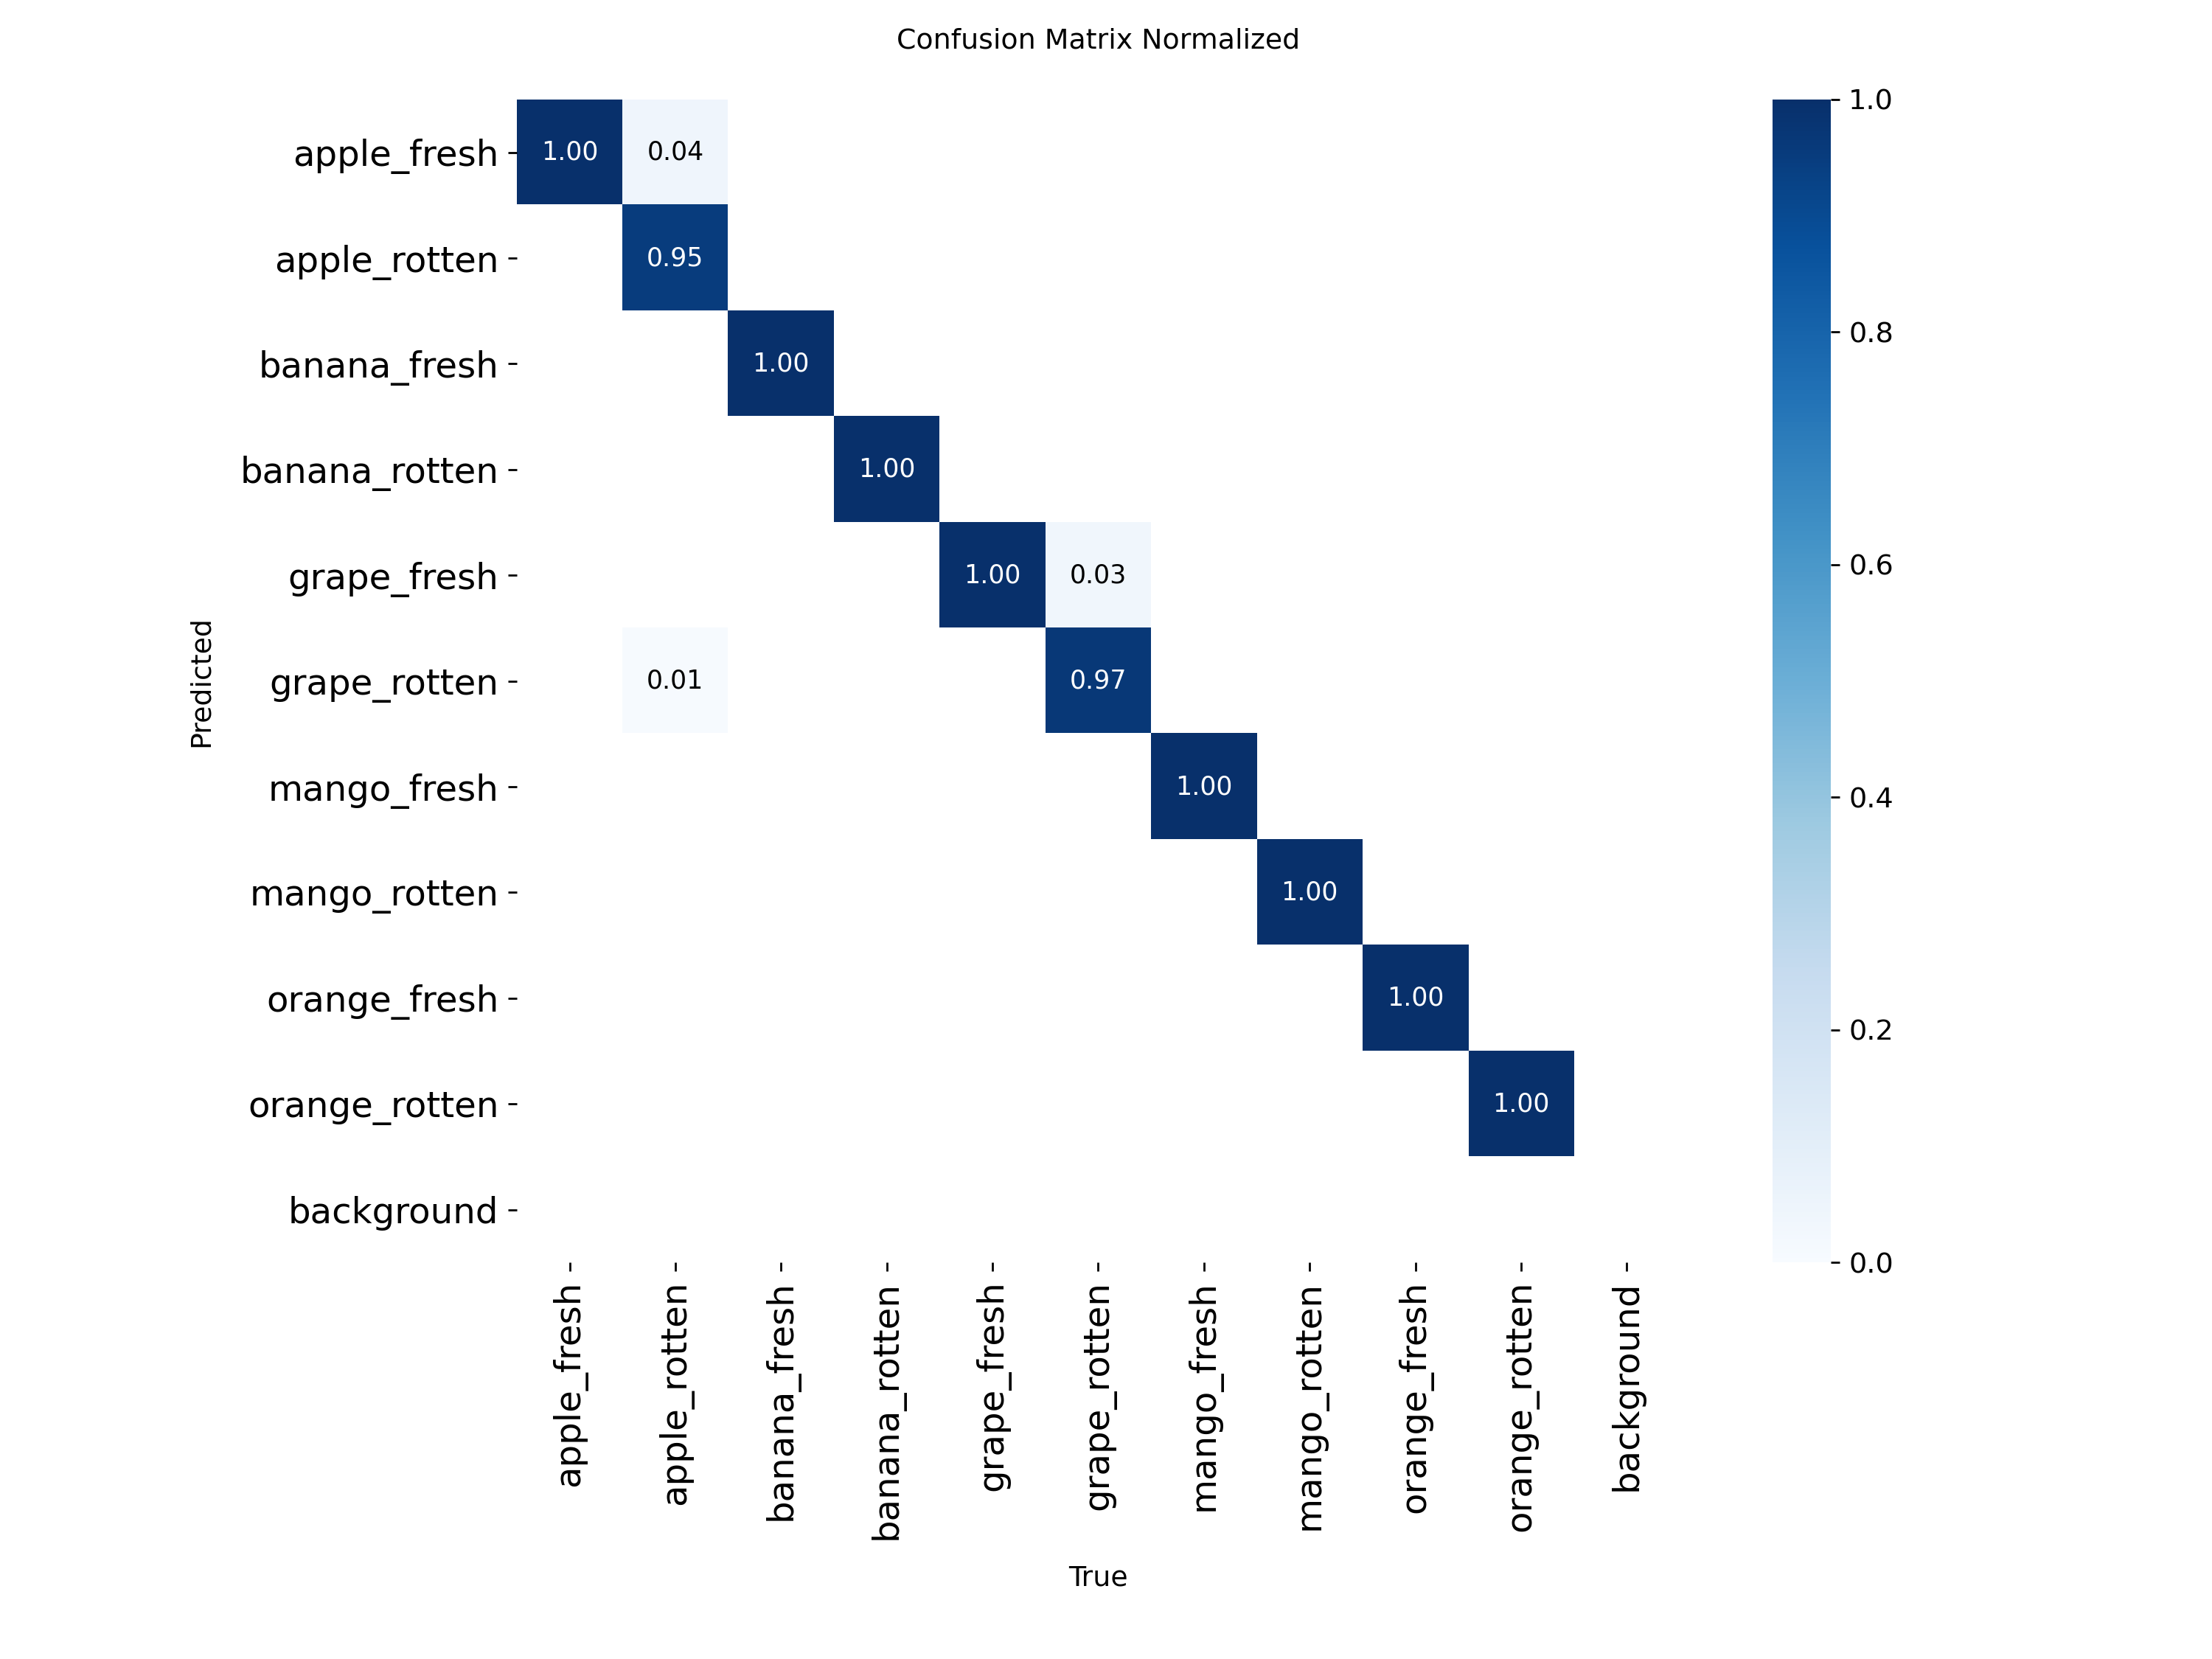

In [ ]:
# INITIAL MODEL CONFUSION MATRIX

%matplotlib inline
from PIL import Image

Image.open('/content/runs/classify/val/confusion_matrix_normalized.png')

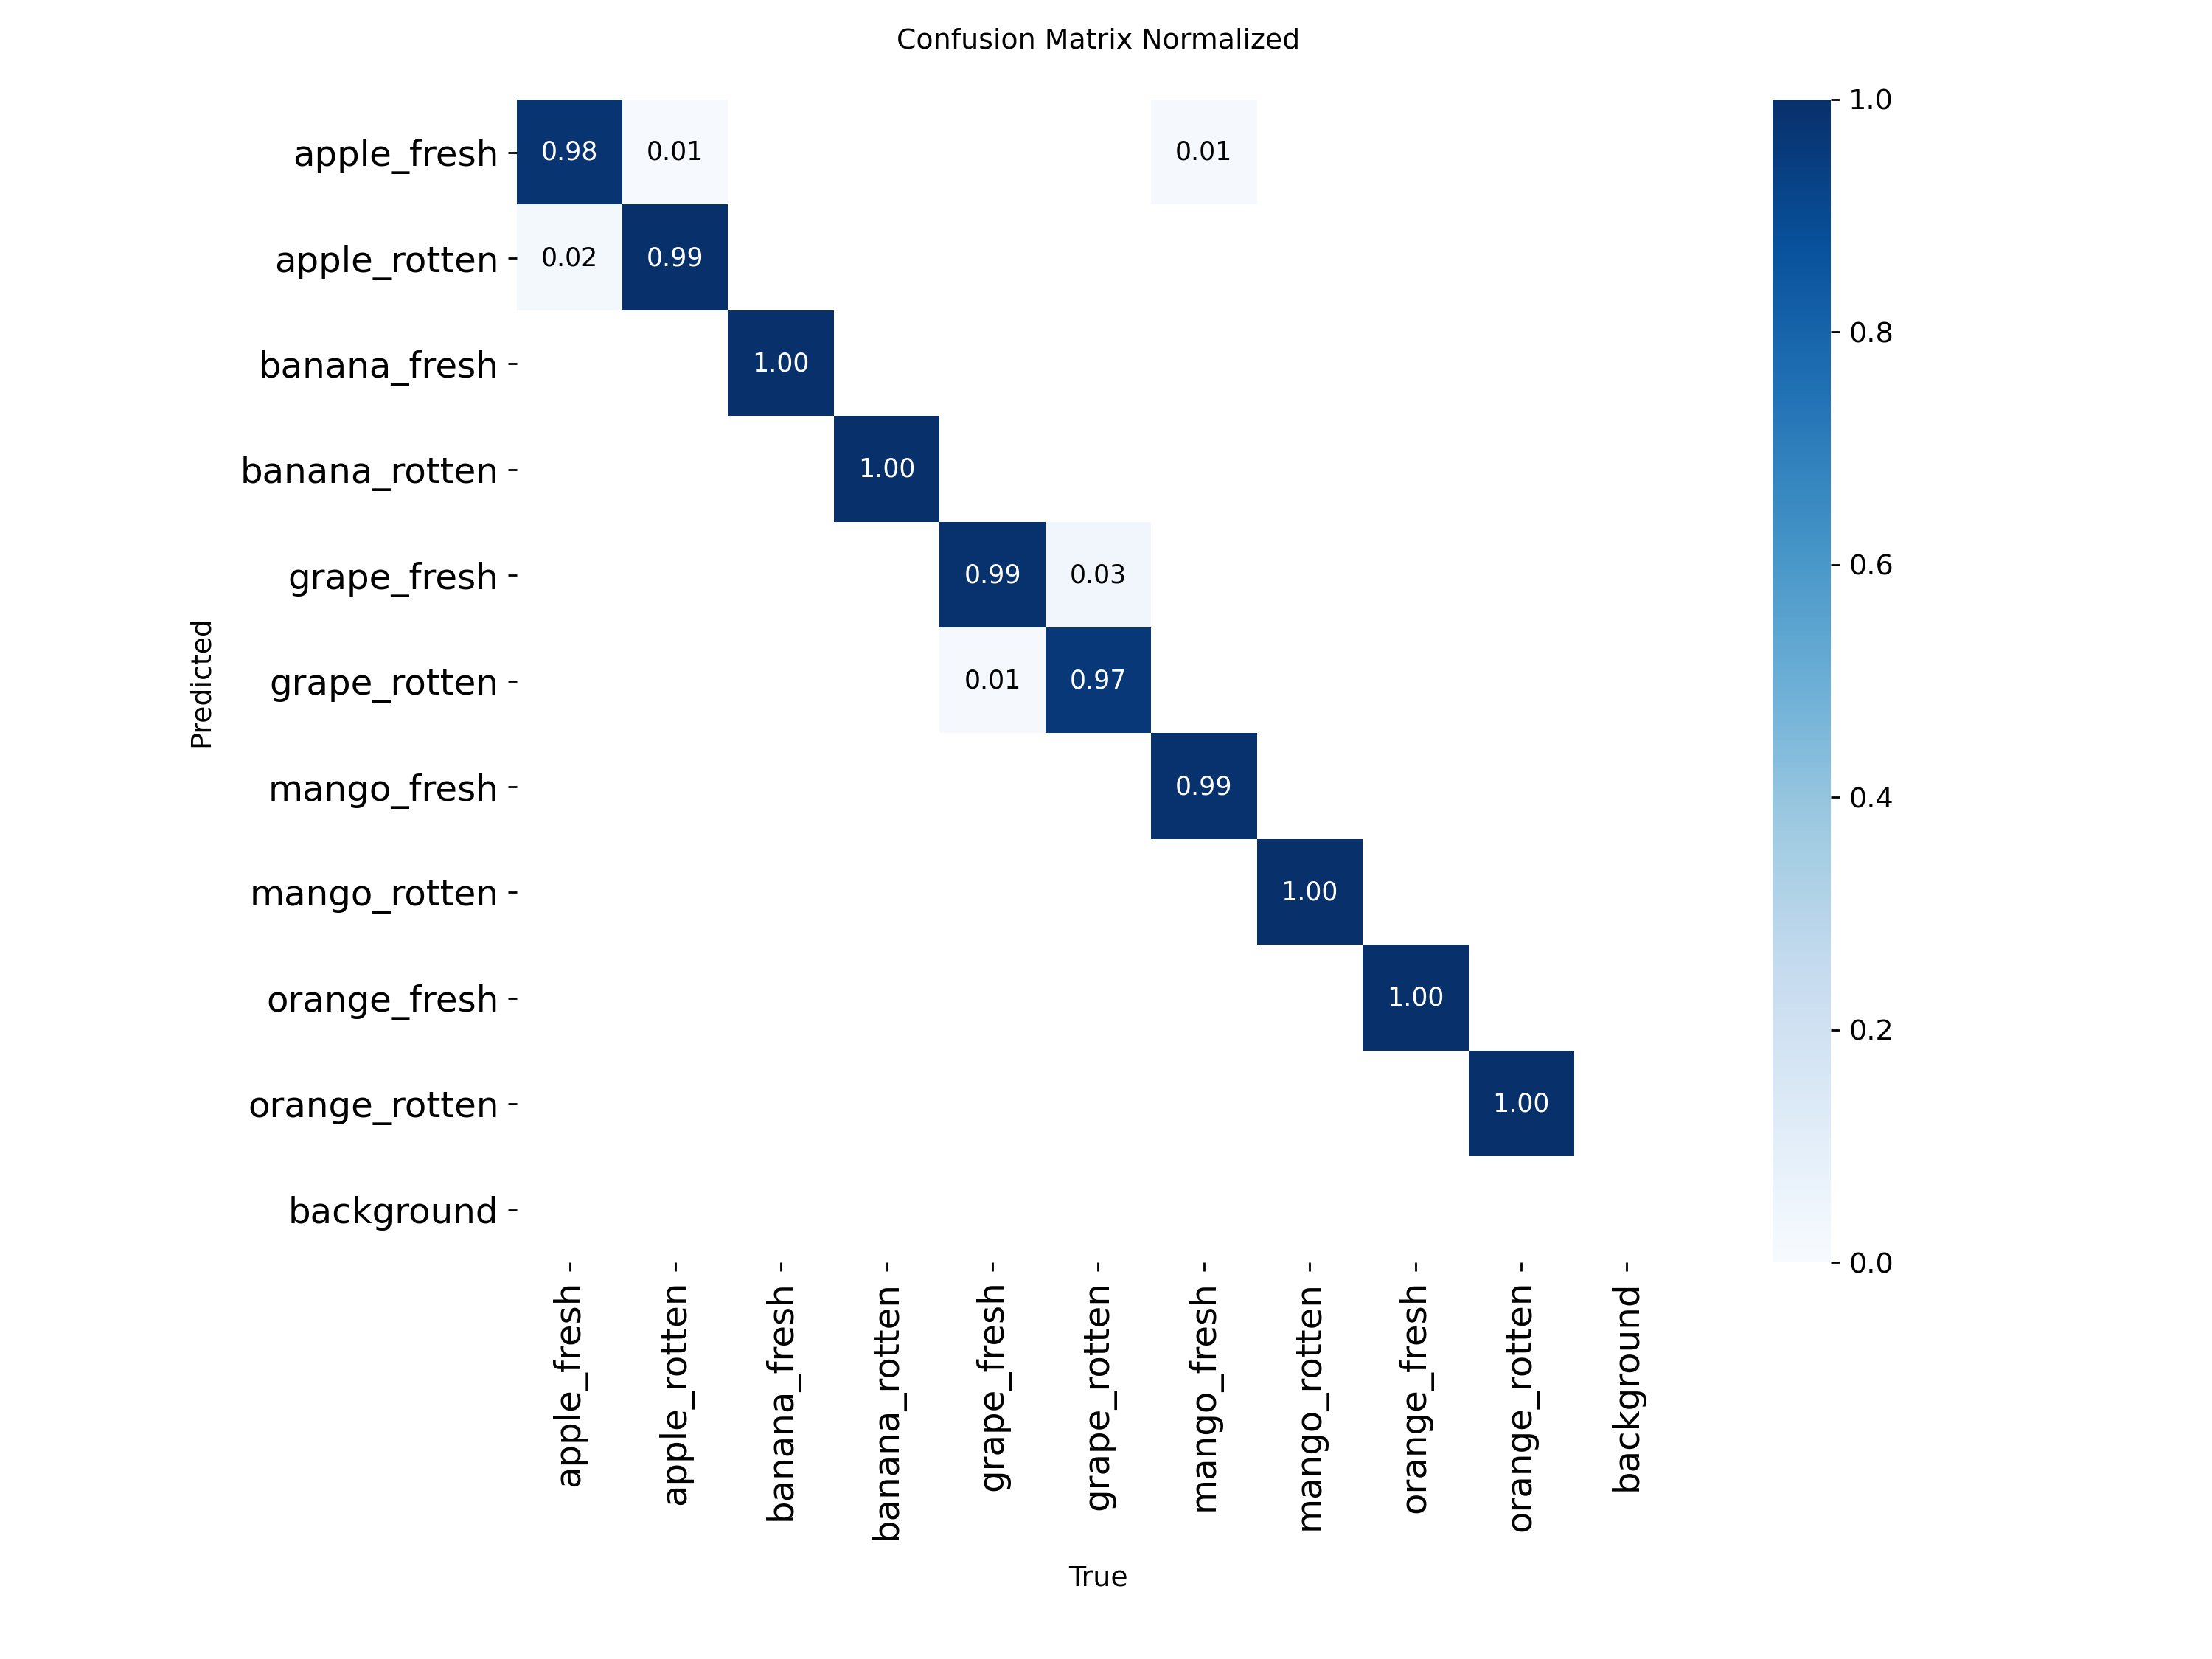

In [ ]:
# CONFUSION MATRIX FOR RETRAINED MODEL

%matplotlib inline
from PIL import Image

Image.open('/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/runs/fine_tuned_model/confusion_matrix_normalized.png')

# Evaluate

In [ ]:
#### DO NOT RERUN THIS CODE!!!!!!!!!!!!!!!


import os
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from ultralytics import YOLO

model = YOLO("/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/runs/fresh_vs_rotten_v1/weights/best.pt")

val_dir = "/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/val"

true_labels = []
pred_labels = []

# Map folder names to numeric labels if needed
classes = sorted([cls for cls in os.listdir(val_dir) if os.path.isdir(os.path.join(val_dir, cls))])
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}

for cls in classes:
    cls_folder = os.path.join(val_dir, cls)

    for img_file in os.listdir(cls_folder):
        if not img_file.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(cls_folder, img_file)
        results = model.predict(img_path, conf=0.0)  # get all predictions

        # YOLOv8 classification usually gives top1 class
        pred = results[0].probs.top1
        if isinstance(pred, torch.Tensor):
            pred = pred.item()

        pred_labels.append(pred)
        true_labels.append(class_to_idx[cls])

accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='macro')  # or 'weighted'
recall = recall_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Streaming output truncated to the last 5000 lines.
Speed: 30.5ms preprocess, 7.8ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/val/banana_fresh/msg5170347760-66650.jpg: 640x640 banana_fresh 1.00, banana_rotten 0.00, apple_fresh 0.00, mango_fresh 0.00, grape_fresh 0.00, 7.8ms
Speed: 30.3ms preprocess, 7.8ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/val/banana_fresh/msg5170347760-69921.jpg: 640x640 banana_fresh 1.00, banana_rotten 0.00, apple_fresh 0.00, grape_rotten 0.00, mango_rotten 0.00, 7.8ms
Speed: 43.7ms preprocess, 7.8ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/val/banana_fresh/msg5170347760-69903.jpg: 640x640 banana_fresh 1.00, banana_rotten 0.00, apple_fresh 0.00, orange_fresh 0.00, apple_rott

In [ ]:
import os
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from ultralytics import YOLO

model = YOLO("/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/runs/fine_tuned_model/weights/best.pt")

val_dir = "/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/val"

true_labels = []
pred_labels = []

# Map folder names to numeric labels if needed
classes = sorted([cls for cls in os.listdir(val_dir) if os.path.isdir(os.path.join(val_dir, cls))])
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}

for cls in classes:
    cls_folder = os.path.join(val_dir, cls)

    for img_file in os.listdir(cls_folder):
        if not img_file.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(cls_folder, img_file)
        results = model.predict(img_path, conf=0.0)  # get all predictions

        # YOLOv8 classification usually gives top1 class
        pred = results[0].probs.top1
        if isinstance(pred, torch.Tensor):
            pred = pred.item()

        pred_labels.append(pred)
        true_labels.append(class_to_idx[cls])

accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='macro')  # or 'weighted'
recall = recall_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Streaming output truncated to the last 5000 lines.
Speed: 19.5ms preprocess, 7.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/val/banana_fresh/msg5170347760-66650.jpg: 640x640 banana_fresh 1.00, banana_rotten 0.00, apple_fresh 0.00, apple_rotten 0.00, mango_fresh 0.00, 7.7ms
Speed: 19.7ms preprocess, 7.7ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/val/banana_fresh/msg5170347760-69921.jpg: 640x640 banana_fresh 1.00, banana_rotten 0.00, apple_fresh 0.00, mango_rotten 0.00, grape_rotten 0.00, 7.7ms
Speed: 19.4ms preprocess, 7.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/val/banana_fresh/msg5170347760-69903.jpg: 640x640 banana_fresh 1.00, banana_rotten 0.00, apple_fresh 0.00, orange_fresh 0.00, orange_ro

##Prediction (for test set)

In [ ]:
from pathlib import Path
from ultralytics import YOLO

model = YOLO("/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/runs/fresh_vs_rotten/weights/best.pt")

# Path to your test images
test_folder = Path("/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/test")

# Collect all jpg/png images (case-insensitive)
image_paths = [p for p in test_folder.rglob("*") if p.suffix.lower() in [".jpg", ".jpeg", ".png"]]
print(f"{len(image_paths)} images")

# Convert to strings for YOLO
image_paths_str = [str(p) for p in image_paths]

# Run predictions on all images
results = model.predict(
    source=image_paths_str,  # use list of paths directly
    project="/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/runs",
    name="fruit_predictions_v1",
    save=True,          # saves output images with boxes
    save_conf=True,     # include confidence scores
    exist_ok=True       # overwrite existing folder if needed
)

print("Predictions complete and saved to Google Drive.")

Found 60 images

0: 640x640 orange_fresh 1.00, orange_rotten 0.00, apple_fresh 0.00, grape_rotten 0.00, banana_fresh 0.00, 516.4ms
1: 640x640 apple_fresh 0.86, apple_rotten 0.14, mango_rotten 0.00, orange_rotten 0.00, mango_fresh 0.00, 516.4ms
2: 640x640 apple_fresh 0.98, orange_fresh 0.02, orange_rotten 0.00, apple_rotten 0.00, banana_rotten 0.00, 516.4ms
3: 640x640 orange_fresh 0.83, apple_fresh 0.15, mango_fresh 0.01, orange_rotten 0.00, apple_rotten 0.00, 516.4ms
4: 640x640 apple_fresh 0.53, orange_rotten 0.30, apple_rotten 0.13, orange_fresh 0.04, mango_rotten 0.00, 516.4ms
5: 640x640 apple_fresh 0.88, apple_rotten 0.12, mango_fresh 0.00, orange_rotten 0.00, orange_fresh 0.00, 516.4ms
6: 640x640 apple_rotten 0.92, apple_fresh 0.07, mango_rotten 0.00, orange_rotten 0.00, grape_rotten 0.00, 516.4ms
7: 640x640 apple_fresh 1.00, apple_rotten 0.00, mango_fresh 0.00, orange_rotten 0.00, mango_rotten 0.00, 516.4ms
8: 640x640 apple_fresh 1.00, apple_rotten 0.00, mango_fresh 0.00, orange_f

<Figure size 800x600 with 0 Axes>

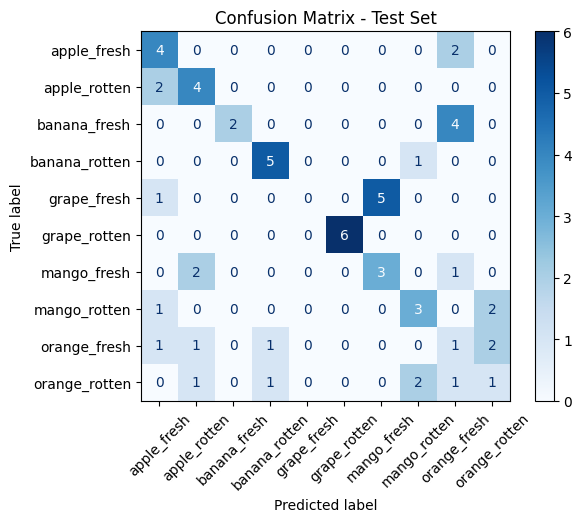

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Find all test images
test_folder = Path("/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/test")
image_paths = list(test_folder.rglob("*.[jp][pn]g"))

true_labels = []
pred_labels = []

for img_path in image_paths:
    true_class = img_path.parent.name        # folder name
    result = model.predict(source=str(img_path), verbose=False, save_txt=False)
    pred_class = result[0].names[result[0].probs.top1]  # predicted class
    true_labels.append(true_class)
    pred_labels.append(pred_class)

labels = sorted(set(true_labels))  # all classes in test set
cm = confusion_matrix(true_labels, pred_labels, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(8,6))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - Test Set")
plt.show()

# Optional: save to Google Drive
# plt.savefig("/content/drive/MyDrive/IAT 360 Computer Vision Project/confusion_matrix_test.png", bbox_inches="tight")

In [ ]:
from pathlib import Path
from ultralytics import YOLO

model = YOLO("/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/runs/fine_tuned_model/weights/best.pt")

# Path to your test images
test_folder = Path("/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/test")

# Collect all jpg/png images (case-insensitive)
image_paths = [p for p in test_folder.rglob("*") if p.suffix.lower() in [".jpg", ".jpeg", ".png"]]
print(f"{len(image_paths)} images")

# Convert to strings for YOLO
image_paths_str = [str(p) for p in image_paths]

# Run predictions on all images
results = model.predict(
    source=image_paths_str,  # use list of paths directly
    project="/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/runs",
    name="fruit_predictions_v1",
    save=True,          # saves output images with boxes
    save_conf=True,     # include confidence scores
    exist_ok=True       # overwrite existing folder if needed
)

print("Predictions complete and saved to Google Drive.")

60 images

0: 640x640 apple_fresh 0.85, apple_rotten 0.11, orange_fresh 0.04, orange_rotten 0.00, banana_fresh 0.00, 4.8ms
1: 640x640 orange_fresh 1.00, apple_fresh 0.00, mango_fresh 0.00, orange_rotten 0.00, banana_fresh 0.00, 4.8ms
2: 640x640 apple_fresh 1.00, orange_fresh 0.00, apple_rotten 0.00, orange_rotten 0.00, grape_rotten 0.00, 4.8ms
3: 640x640 orange_fresh 0.52, apple_fresh 0.43, orange_rotten 0.03, apple_rotten 0.01, grape_rotten 0.00, 4.8ms
4: 640x640 apple_fresh 0.64, orange_fresh 0.19, apple_rotten 0.11, orange_rotten 0.06, banana_fresh 0.00, 4.8ms
5: 640x640 apple_fresh 0.94, apple_rotten 0.06, orange_fresh 0.00, mango_rotten 0.00, grape_rotten 0.00, 4.8ms
6: 640x640 apple_rotten 0.95, apple_fresh 0.05, orange_rotten 0.00, orange_fresh 0.00, mango_rotten 0.00, 4.8ms
7: 640x640 apple_fresh 0.82, apple_rotten 0.18, mango_fresh 0.00, grape_rotten 0.00, orange_fresh 0.00, 4.8ms
8: 640x640 apple_rotten 1.00, apple_fresh 0.00, grape_rotten 0.00, mango_fresh 0.00, banana_rotte

<Figure size 800x600 with 0 Axes>

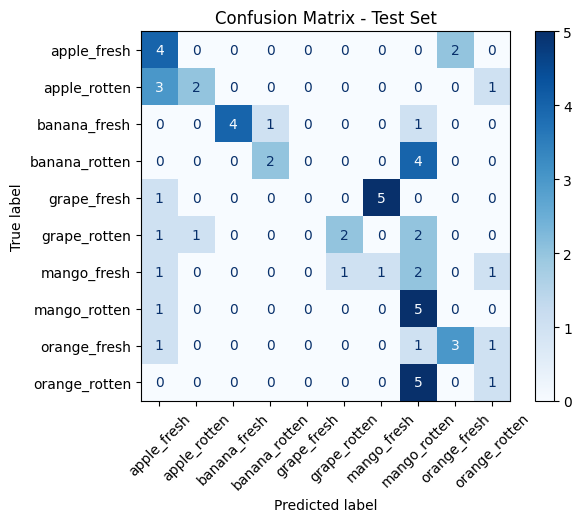

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Find all test images
test_folder = Path("/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/test")
image_paths = list(test_folder.rglob("*.[jp][pn]g"))

true_labels = []
pred_labels = []

for img_path in image_paths:
    true_class = img_path.parent.name        # folder name
    result = model.predict(source=str(img_path), verbose=False, save_txt=False)
    pred_class = result[0].names[result[0].probs.top1]  # predicted class
    true_labels.append(true_class)
    pred_labels.append(pred_class)

labels = sorted(set(true_labels))  # all classes in test set
cm = confusion_matrix(true_labels, pred_labels, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(8,6))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - Test Set")
plt.show()

Found 60 test images
Results saved to /content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/runs/fruit_predictions_v23
Predictions complete and saved to Google Drive.


<Figure size 800x600 with 0 Axes>

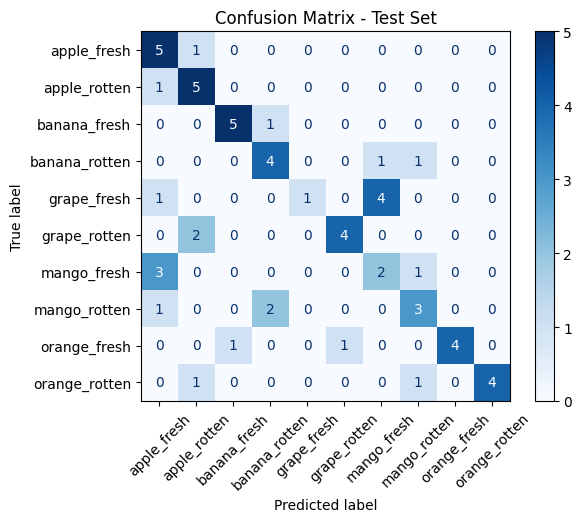

In [12]:
from pathlib import Path
from ultralytics import YOLO
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load model
model = YOLO("/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/runs/fresh_vs_rotten_v23/weights/epoch2.pt")

# Path to test images
test_folder = Path("/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/test")
image_paths = [p for p in test_folder.rglob("*") if p.suffix.lower() in [".jpg", ".jpeg", ".png"]]
print(f"Found {len(image_paths)} test images")

# Convert paths to strings
image_paths_str = [str(p) for p in image_paths]

# Run predictions and save output images
results = model.predict(
    source=image_paths_str,
    project="/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/runs",
    name="fruit_predictions_v23",
    save=True,          # save images with boxes
    save_conf=True,     # include confidence scores
    verbose=False,
    exist_ok=True
)

print("Predictions complete and saved to Google Drive.")

# Extract true labels and predicted labels
true_labels = []
pred_labels = []

for img_path, result in zip(image_paths, results):
    true_class = img_path.parent.name
    pred_class = result.names[result.probs.top1]
    true_labels.append(true_class)
    pred_labels.append(pred_class)

# Plot confusion matrix
labels = sorted(set(true_labels))
cm = confusion_matrix(true_labels, pred_labels, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(8,6))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - Test Set")
plt.show()

Found 60 test images
Results saved to /content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/runs/fruit_predictions_v42
Predictions complete and saved to Google Drive.


<Figure size 800x600 with 0 Axes>

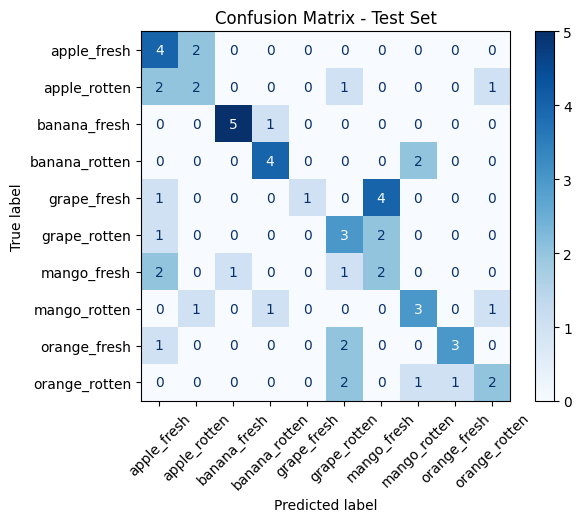

In [7]:
from pathlib import Path
from ultralytics import YOLO
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load model
model = YOLO("/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/runs/fresh_vs_rotten_v42/weights/epoch0.pt")

# Path to test images
test_folder = Path("/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/test")
image_paths = [p for p in test_folder.rglob("*") if p.suffix.lower() in [".jpg", ".jpeg", ".png"]]
print(f"Found {len(image_paths)} test images")

# Convert paths to strings
image_paths_str = [str(p) for p in image_paths]

# Run predictions and save output images
results = model.predict(
    source=image_paths_str,
    project="/content/drive/MyDrive/IAT 360 Computer Vision Project/dataset/runs",
    name="fruit_predictions_v42",
    save=True,          # save images with boxes
    save_conf=True,     # include confidence scores
    verbose=False,
    exist_ok=True
)

print("Predictions complete and saved to Google Drive.")

# Extract true labels and predicted labels
true_labels = []
pred_labels = []

for img_path, result in zip(image_paths, results):
    true_class = img_path.parent.name
    pred_class = result.names[result.probs.top1]
    true_labels.append(true_class)
    pred_labels.append(pred_class)

# Plot confusion matrix
labels = sorted(set(true_labels))
cm = confusion_matrix(true_labels, pred_labels, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(8,6))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - Test Set")
plt.show()